In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import feather
from datetime import date, datetime

In [2]:
data_path = '/Volumes/FileStorage/Insight_data/'
ohio_path = '/Volumes/FileStorage/Insight_data/Ohio_data/data_feather/'

In [3]:
oh_df=feather.read_dataframe(ohio_path+'updated_df.feather')

In [4]:
election_list = []
election_i = []
general_list = []
primary_list = []
for key in oh_df:
        if key[:7]=='GENERAL':
                election_list.append(key)
                general_list.append(key)
        elif key[:7]=='PRIMARY':
                election_list.append(key)
                primary_list.append(key)
        elif key[:7]=='SPECIAL':
                election_list.append(key)
                
def el_to_date(election):
    el_date_str = election.split('-')[1]
    el_obj = datetime.strptime(el_date_str, '%m/%d/%Y')
    return el_obj
date_list = [el_to_date(e) for e in election_list]
date_dict = dict(zip(election_list, date_list))

In [5]:
oh_df.head()

,SOS_VOTERID,COUNTY_NUMBER,COUNTY_ID,LAST_NAME,FIRST_NAME,MIDDLE_NAME,SUFFIX,DATE_OF_BIRTH,REGISTRATION_DATE,VOTER_STATUS,...,AGE_2012,AGE_2020,N_VOTED_ELIGIBLE,N_ELIGIBLE,N_VOTED_ELIGIBLE_2012,N_ELIGIBLE_2012,N_VOTED_ELIGIBLE_2016,N_ELIGIBLE_2016,N_VOTED_ELIGIBLE_2020,N_ELIGIBLE_2020
0,OH0019419095,6,40055,KITCHEN,LESLIE,L,None,1969-12-26,2008-01-09,ACTIVE,...,42,50,2,38,0,17,1,30,2,35
1,OH0019489283,9,482703,GRACE,AMANDA,LEIGH,None,1974-11-09,2008-02-01,ACTIVE,...,37,45,10,38,4,17,8,30,9,35
2,OH0015384921,18,2044314,CARNER,TIFFANY,J,None,1971-08-28,2016-05-25,ACTIVE,...,41,49,0,10,0,0,0,2,0,10
3,OH0020115764,13,6100757,VAN SCYOC,SUSAN,L,None,1973-08-01,2008-09-18,ACTIVE,...,39,47,7,37,3,16,6,29,6,35
4,OH0015058130,18,1674659,BERRY,NICOLE,L,None,1975-04-25,2009-08-19,ACTIVE,...,37,45,11,33,4,12,8,25,11,33


In [57]:
for key in oh_df:
    print(key)

SOS_VOTERID
COUNTY_NUMBER
COUNTY_ID
LAST_NAME
FIRST_NAME
MIDDLE_NAME
SUFFIX
DATE_OF_BIRTH
REGISTRATION_DATE
VOTER_STATUS
PARTY_AFFILIATION
RESIDENTIAL_ADDRESS1
RESIDENTIAL_SECONDARY_ADDR
RESIDENTIAL_CITY
RESIDENTIAL_STATE
RESIDENTIAL_ZIP
RESIDENTIAL_ZIP_PLUS4
RESIDENTIAL_COUNTRY
RESIDENTIAL_POSTALCODE
MAILING_ADDRESS1
MAILING_SECONDARY_ADDRESS
MAILING_CITY
MAILING_STATE
MAILING_ZIP
MAILING_ZIP_PLUS4
MAILING_COUNTRY
MAILING_POSTAL_CODE
CAREER_CENTER
CITY
CITY_SCHOOL_DISTRICT
COUNTY_COURT_DISTRICT
CONGRESSIONAL_DISTRICT
COURT_OF_APPEALS
EDU_SERVICE_CENTER_DISTRICT
EXEMPTED_VILL_SCHOOL_DISTRICT
LIBRARY
LOCAL_SCHOOL_DISTRICT
MUNICIPAL_COURT_DISTRICT
PRECINCT_NAME
PRECINCT_CODE
STATE_BOARD_OF_EDUCATION
STATE_REPRESENTATIVE_DISTRICT
STATE_SENATE_DISTRICT
TOWNSHIP
VILLAGE
WARD
PRIMARY-03/07/2000
GENERAL-11/07/2000
SPECIAL-05/08/2001
GENERAL-11/06/2001
PRIMARY-05/07/2002
GENERAL-11/05/2002
SPECIAL-05/06/2003
GENERAL-11/04/2003
PRIMARY-03/02/2004
GENERAL-11/02/2004
SPECIAL-02/08/2005
PRIMARY-05

In [ ]:
oh_df.fillna('-1').groupby(['GENERAL-11/06/2012']).size()

In [6]:
oh_df.fillna('-1').groupby(['GENERAL-11/06/2012','GENERAL-11/08/2016']).size()

GENERAL-11/06/2012  GENERAL-11/08/2016
-1                  -1                    1755906
                    X                     1070792
X                   -1                     670999
                    X                     4327688
dtype: int64

In [9]:
def row_ratio(row,year):
    eligible_column = 'N_ELIGIBLE_'+year
    voted_column = 'N_VOTED_ELIGIBLE_'+year
    voted_i= row[voted_column]
    eligible_i = row[eligible_column]
    if eligible_i != 0:
        v_ratio = voted_i/eligible_i
    else:
        v_ratio = 0
    return v_ratio

In [14]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

In [11]:
oh_df['RATIO_2012'] = oh_df.progress_apply(lambda row: row_ratio(row,'2012'), axis=1)
oh_df['RATIO_2016'] = oh_df.progress_apply(lambda row: row_ratio(row,'2016'), axis=1)
oh_df['RATIO_2020'] = oh_df.progress_apply(lambda row: row_ratio(row,'2020'), axis=1)

In [12]:
feather.write_dataframe(oh_df,'/Volumes/FileStorage/Insight_data/Ohio_data/data_feather/updated_oh_withratio.feather')

In [10]:
oh_df=feather.read_dataframe(ohio_path+'updated_oh_withratio.feather')

In [11]:
%matplotlib inline

[Text(0, 0.5, 'Voters'), Text(0.5, 0, '#Presidential elections')]

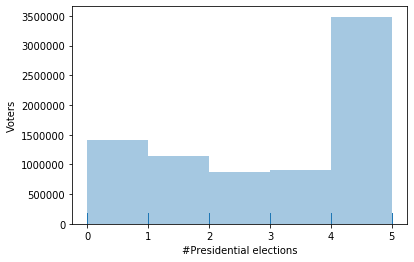

In [12]:
import seaborn

presidential_list=['GENERAL-11/07/2000','GENERAL-11/02/2004','GENERAL-11/04/2008','GENERAL-11/06/2012','GENERAL-11/08/2016']
presidential_n=oh_df[presidential_list].notnull().sum(axis=1)
ax = seaborn.distplot(presidential_n,bins=5,kde=False, rug=True);
ax.set(xlabel='#Presidential elections', ylabel='Voters')

In [15]:
oh_df['GENERAL-11/06/2012'] = oh_df['GENERAL-11/06/2012'].astype('category')
oh_df['GENERAL-11/08/2016'] = oh_df['GENERAL-11/08/2016'].astype('category')

el_train_list=['GENERAL-11/06/2012','GENERAL-11/08/2016']
oh_df['GENERAL-11/06/2012'].cat.codes.head()
oh_df[el_train_list] = oh_df[el_train_list].progress_apply(lambda x: x.cat.codes)

In [181]:
traits=['AGE_2016','GENERAL-11/06/2012','RATIO_2016','HC02_EST_VC17','HC02_EST_VC18','GENERAL-11/08/2016']
traits_plot=['Age','Voted 2012','Ratio(Voted/Elections)','% High School Diploma','% Bachelors Degree','Voted 2016']

In [56]:
census_df=feather.read_dataframe('/Volumes/FileStorage/Insight_data/census_data/census.feather')

In [67]:
print(oh_df['RESIDENTIAL_ZIP'].dtype)
print(census_df['GEO.id2'].dtype)

int64
object


In [69]:
oh_df['RESIDENTIAL_ZIP']=oh_df['RESIDENTIAL_ZIP'].apply(str)

In [75]:
#df.rename(columns={"A": "a"})
census_df=census_df.rename(columns={'GEO.id2':'RESIDENTIAL_ZIP'})

In [95]:
oh_df.shape

(7825385, 120)

In [89]:
oh_census_df=pd.merge(oh_df,census_df,on=['RESIDENTIAL_ZIP'],how='left').progress_apply(lambda x: x)

In [90]:
oh_census_df.shape

(7825385, 123)

In [104]:
#'coerce' forces non-numeric strings to NaN
oh_census_df['HC02_EST_VC17']=pd.to_numeric(oh_census_df['HC02_EST_VC17'],errors='coerce')

In [108]:
oh_census_df['HC01_EST_VC13']=pd.to_numeric(oh_census_df['HC01_EST_VC13'],errors='coerce')
oh_census_df['HC02_EST_VC18']=pd.to_numeric(oh_census_df['HC02_EST_VC18'],errors='coerce')

In [119]:
#df.fillna(df.mean(), inplace=True)
oh_census_df['HC02_EST_VC17'].fillna(oh_census_df['HC02_EST_VC17'].mean(),inplace=True)
oh_census_df['HC01_EST_VC13'].fillna(oh_census_df['HC01_EST_VC13'].mean(),inplace=True)
oh_census_df['HC02_EST_VC18'].fillna(oh_census_df['HC02_EST_VC18'].mean(),inplace=True)

In [139]:
oh_census_df[traits].isnull().values.any()

False

In [120]:
feather.write_dataframe(oh_census_df,'/Volumes/FileStorage/Insight_data/Ohio_data/data_feather/oh_census_df.feather')

In [182]:
correlations=oh_census_df[traits].corr()
print(correlations)

                    AGE_2016  GENERAL-11/06/2012  RATIO_2016  HC02_EST_VC17  \
AGE_2016            1.000000            0.448019    0.492173       0.026064   
GENERAL-11/06/2012  0.448019            1.000000    0.552881       0.078460   
RATIO_2016          0.492173            0.552881    1.000000       0.089193   
HC02_EST_VC17       0.026064            0.078460    0.089193       1.000000   
HC02_EST_VC18      -0.033695            0.040196    0.024145       0.683104   
GENERAL-11/08/2016  0.330085            0.505698    0.493892       0.109566   

                    HC02_EST_VC18  GENERAL-11/08/2016  
AGE_2016                -0.033695            0.330085  
GENERAL-11/06/2012       0.040196            0.505698  
RATIO_2016               0.024145            0.493892  
HC02_EST_VC17            0.683104            0.109566  
HC02_EST_VC18            1.000000            0.073234  
GENERAL-11/08/2016       0.073234            1.000000  


['Age', 'Voted 2012', 'Ratio(Voted/Elections)', '% High School Diploma', '% Bachelors Degree', 'Voted 2016']


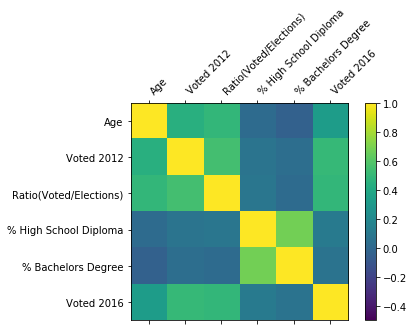

In [183]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-0.5, vmax=1)
fig.colorbar(cax)
print(traits_plot)
ax.set_xticks(np.arange(0,correlations.shape[0], correlations.shape[0]*1.0/len(traits_plot)))
ax.set_yticks(np.arange(0,correlations.shape[1], correlations.shape[1]*1.0/len(traits_plot)))
ax.set_xticklabels(traits_plot,rotation=45,ha="left")
ax.set_yticklabels(traits_plot)
ax.set_ylim(len(correlations)-0.5, -0.5)
plt.show()

In [123]:
from sklearn.model_selection import train_test_split

def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [141]:
df_train, df_valid, df_test = train_validate_test_split(oh_census_df,seed=1)
feather.write_dataframe(df_train,'/Volumes/FileStorage/Insight_data/Ohio_data/data_feather/oh_census_train_set.feather')
feather.write_dataframe(df_valid,'/Volumes/FileStorage/Insight_data/Ohio_data/data_feather/oh_census_valid_set.feather')
feather.write_dataframe(df_test,'/Volumes/FileStorage/Insight_data/Ohio_data/data_feather/oh_census_test_set.feather')

In [186]:
#features=['AGE_2016','GENERAL-11/06/2012','RATIO_2016','HC01_EST_VC13','HC02_EST_VC17','HC02_EST_VC18']
features=['AGE_2016','GENERAL-11/06/2012','RATIO_2016','HC02_EST_VC17','HC02_EST_VC18']
X_train = df_train.loc[:, features]
Y_train = df_train['GENERAL-11/08/2016']

X_valid = df_valid.loc[:, features]
Y_valid = df_valid['GENERAL-11/08/2016']

X_test = df_test.loc[:, features]
Y_test = df_test['GENERAL-11/08/2016']

In [187]:
print(oh_census_df[traits].isnull().values.any())

print(X_test.isnull().values.any())

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='lbfgs')

logreg.fit(X_train, Y_train)

False
False


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [188]:
predictions = logreg.predict(X_valid)
score = logreg.score(X_valid, Y_valid)
print(score)

0.8054600508473385


In [189]:
from joblib import dump, load
dump(logreg, 'logreg_fulldata_census.joblib') 

['logreg_fulldata_census.joblib']

In [190]:
predictions = logreg.predict(X_test)
score = logreg.score(X_test, Y_test)
print(score)

0.8055079718122495


In [29]:
y_y = 2138780
n_n = 773260
n_y = 466904
y_n = 303038

tot_v = y_y+n_n+n_y+y_n
acc_baseline = (y_y+n_n)/tot_v
print(acc_baseline)

0.7908892547546403


In [32]:
df_test.groupby(['GENERAL-11/06/2012','GENERAL-11/08/2016']).size()

GENERAL-11/06/2012  GENERAL-11/08/2016
-1                  -1                    351338
                     0                    213563
 0                  -1                    134139
                     0                    866037
dtype: int64

In [37]:
acc_baseline_testset=(351338+866037)/(351338+213563+134139+866037)
print(acc_baseline_testset)

0.7778371287802454


In [36]:
df_test.groupby(['GENERAL-11/06/2012','GENERAL-11/08/2016']).head()

,SOS_VOTERID,COUNTY_NUMBER,COUNTY_ID,LAST_NAME,FIRST_NAME,MIDDLE_NAME,SUFFIX,DATE_OF_BIRTH,REGISTRATION_DATE,VOTER_STATUS,...,N_ELIGIBLE,N_VOTED_ELIGIBLE_2012,N_ELIGIBLE_2012,N_VOTED_ELIGIBLE_2016,N_ELIGIBLE_2016,N_VOTED_ELIGIBLE_2020,N_ELIGIBLE_2020,RATIO_2012,RATIO_2016,RATIO_2020
7505750,OH0024731553,84,10235287,ALLEN,LAUREN,MCCALL,None,2000-03-03,2018-08-24,ACTIVE,...,2,0,0,0,0,0,2,0.000000,0.000000,0.000000
4365076,OH0024725632,32,150137,MISAMORE,ETHAN,None,None,1998-12-26,2017-04-23,ACTIVE,...,7,0,0,0,0,0,7,0.000000,0.000000,0.000000
3926070,OH0017268664,25,772404623,MONTESI,SHIRLEY,A,None,1950-08-05,1900-01-01,ACTIVE,...,60,16,37,15,42,14,35,0.432432,0.357143,0.400000
3365988,OH0014011949,31,113782,WINFREY,MARCELLENE,S,None,1949-12-04,1989-07-17,ACTIVE,...,60,15,37,13,42,10,35,0.405405,0.309524,0.285714
4014989,OH0012755104,35,9703547,SALAZ,DEBORAH,ANN,None,1967-01-01,2013-11-04,CONFIRMATION,...,17,0,0,0,9,0,17,0.000000,0.000000,0.000000
1725894,OH0024308185,18,2795376,FILLINGER,APRIL,M,None,1984-04-13,2019-07-29,ACTIVE,...,0,0,0,0,0,0,0,0.000000,0.000000,0.000000
5681778,OH0011286179,57,9027637,MADISON,TOSHA,J,None,1968-12-30,1992-12-11,ACTIVE,...,60,3,37,6,42,10,35,0.081081,0.142857,0.285714
6332939,OH0012606715,81,111114390,BRINCEFIELD,ALISHA,K,None,1983-07-18,2002-03-15,ACTIVE,...,56,10,35,8,42,5,35,0.285714,0.190476,0.142857
4926899,OH0012596665,54,78000261,WEAVER,LARRY,DEAN,None,1957-05-22,1978-01-23,ACTIVE,...,60,16,37,16,42,17,35,0.432432,0.380952,0.485714
7582060,OH0023622340,67,9827482,PIZZINO,DAWSON,ANTHONY,None,1998-03-23,2016-03-29,ACTIVE,...,10,0,0,0,2,0,10,0.000000,0.000000,0.000000


In [ ]:
traits_2020=['AGE_2020','GENERAL-11/08/2016','RATIO_2020']

In [4]:
oh_df.fillna('-1').groupby(['GENERAL-11/06/2012','GENERAL-11/08/2016']).size()

GENERAL-11/06/2012  GENERAL-11/08/2016
-1                  -1                    1755906
                    X                     1070792
X                   -1                     670999
                    X                     4327688
dtype: int64

In [62]:
nn=1755906
ny=1070792
yn=670999
yy=4327688
tot=nn+ny+yn+yy
print((nn+yy)/tot)
#77.74% predictive power in whole dataset

0.777417852284584


In [184]:
print(nn/tot)
print(ny/tot)
print(yn/tot)
print(yy/tot)

0.22438589283466565
0.13683569562392137
0.08574645209149453
0.5530319594499185


In [185]:
22+14+9+55

100

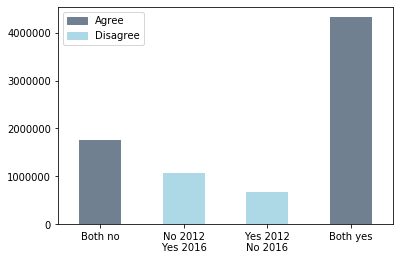

In [211]:
import matplotlib.patches as mpatches

s=pd.Series([nn,ny,yn,yy],index=['Both no','No 2012\nYes 2016','Yes 2012\nNo 2016','Both yes'])
c=['slategrey','lightblue','lightblue','slategrey']
s.plot(kind='bar',color=c)
plt.xticks(rotation=360)
agree=mpatches.Patch(color='slategrey', label='Agree')
disagree=mpatches.Patch(color='lightblue',label='Disagree')
plt.legend(handles=[agree,disagree])
plt.show()